In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
   print("Your Colab notebook is configured to run on the GPU!")
else:
   print("If you see this message, your Colab notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your Colab notebook is configured to run on the GPU!


In [2]:
import numpy as np
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
cd /content/drive/MyDrive/Colab Notebooks/Semi-supervised Project

/content/drive/MyDrive/Colab Notebooks/Semi-supervised Project


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


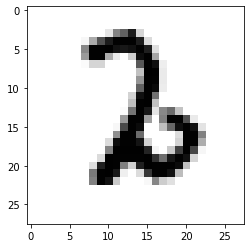

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

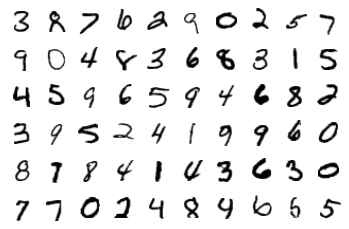

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [10]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [11]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-3.8506e-03, -3.8506e-03, -3.8506e-03,  ..., -3.8506e-03,
         -3.8506e-03, -3.8506e-03],
        [ 5.0904e-06,  5.0904e-06,  5.0904e-06,  ...,  5.0904e-06,
          5.0904e-06,  5.0904e-06],
        [ 3.2316e-03,  3.2316e-03,  3.2316e-03,  ...,  3.2316e-03,
          3.2316e-03,  3.2316e-03],
        ...,
        [-2.4942e-03, -2.4942e-03, -2.4942e-03,  ..., -2.4942e-03,
         -2.4942e-03, -2.4942e-03],
        [-4.1006e-04, -4.1006e-04, -4.1006e-04,  ..., -4.1006e-04,
         -4.1006e-04, -4.1006e-04],
        [-5.8795e-04, -5.8795e-04, -5.8795e-04,  ..., -5.8795e-04,
         -5.8795e-04, -5.8795e-04]])


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.637324841673186
Epoch 1 - Training loss: 0.2858310529529286
Epoch 2 - Training loss: 0.2169531657060644
Epoch 3 - Training loss: 0.17332109501525791
Epoch 4 - Training loss: 0.14487367244298333
Epoch 5 - Training loss: 0.12355251354910037
Epoch 6 - Training loss: 0.10826308269407163
Epoch 7 - Training loss: 0.0956050930802883
Epoch 8 - Training loss: 0.08654874710759311
Epoch 9 - Training loss: 0.07699218900131582
Epoch 10 - Training loss: 0.07024183711990206
Epoch 11 - Training loss: 0.06329102329572221
Epoch 12 - Training loss: 0.0595007059283491
Epoch 13 - Training loss: 0.05433090852520395
Epoch 14 - Training loss: 0.04975078154954988

Training Time (in minutes) = 2.458227753639221


In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


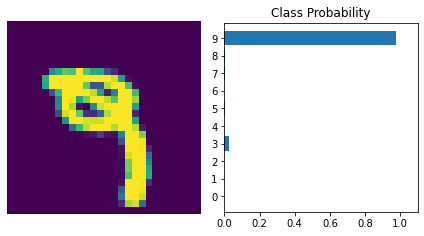

In [14]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [15]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9731
